In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from TrialSolution import TrialSolution

/home/raroog/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Example 4

$$\frac{d}{dx}\Psi_1=\cos(x)+\Psi_1^2+\Psi_2-(1+x^2+\sin^2(x))$$
$$\frac{d}{dx}\Psi_2=2x -(1+x^2)\sin(x)+\Psi_1\Psi_2$$

With boundary initial condition $\Psi_1(0)=0$, $\Psi_2(0)=1$ and domain $x\in[0,3]$

In [3]:
inits = [{'variable':0, 'value':0, 'type':'dirichlet', 'ode_number':1,
        'function':lambda X: tf.constant(0., dtype='float64', shape=(X.shape[0],1))},
        {'variable':0, 'value':0, 'type':'dirichlet', 'ode_number':2,
        'function':lambda X: tf.constant(1., dtype='float64', shape=(X.shape[0],1))}]

In [23]:
X_train = np.arange(0, 3, 0.2) + 1e-8
X_train = X_train.reshape(-1,1)
X_test = np.arange(0, 3, 0.01) + 1e-8
X_test = X_test.reshape(-1,1)

The trial solutions for the case are $\Psi_1(x)=xN_1(x)$ and $\Psi_1(x)=1+xN_1(x)$.
Though, in our case, the trial solution is generated automatically from the initial conditions.

In [5]:
ts = TrialSolution(conditions=inits, n_i=1, n_h=10, n_o=1, ODE_number=2, equation_type='ODE_system')

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(L\Psi(x_i, N(x_i))-f(x_i,\Psi(x_i, N(x_i))) \right)^2$$
Where $N(x)$ is the neural network and $L$ is some differential operator.

In [6]:
def diff_loss(network, inputs):
  with tf.GradientTape() as tape1:
    inputs = tf.convert_to_tensor(inputs)
    tape1.watch(inputs)
    response1 = network(inputs)[0]
  grads1 = tape1.gradient(response1, inputs)  
  with tf.GradientTape() as tape2:
    inputs = tf.convert_to_tensor(inputs)
    tape2.watch(inputs)
    response2 = network(inputs)[1]
  grads2 = tape2.gradient(response2, inputs)
  loss1 = (grads1 - tf.cos(inputs) - response1**2 - response2 + tf.constant(1, dtype='float64')
           + inputs ** 2 + tf.sin(inputs) ** 2)
  loss2 = (grads2 - tf.constant(2., dtype='float64') * inputs 
           + (tf.constant(1., dtype='float64') + inputs**2) * tf.sin(inputs) - response1*response2)
  loss = tf.square(loss1) + tf.square(loss2)
  return loss

### Training

In [7]:
ts.train(X=X_train, diff_loss=diff_loss, epochs=10000, message_frequency=1000, optimizer_name='Adam', learning_rate=0.01)

Epoch: 1000 Loss: 0.2170192152261734
Epoch: 2000 Loss: 0.11109744012355804
Epoch: 3000 Loss: 0.0748516321182251
Epoch: 4000 Loss: 0.05645676329731941
Epoch: 5000 Loss: 0.0453525148332119
Epoch: 6000 Loss: 0.03791990131139755
Epoch: 7000 Loss: 0.03259696811437607
Epoch: 8000 Loss: 0.028608020395040512
Epoch: 9000 Loss: 0.025535035878419876
Epoch: 10000 Loss: 0.02304312400519848


### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

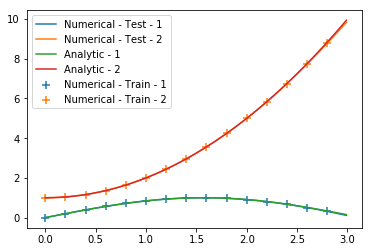

In [28]:
pred1 = ts.call(tf.convert_to_tensor(Xs, dtype='float64'))[0].numpy()
pred2 = ts.call(tf.convert_to_tensor(Xs, dtype='float64'))[1].numpy()
pred1_test = ts.call(tf.convert_to_tensor(X_test, dtype='float64'))[0].numpy()
pred2_test = ts.call(tf.convert_to_tensor(X_test, dtype='float64'))[1].numpy()
plt.scatter(X_train, pred1, label='Numerical - Train - 1', marker='+', s=50)
plt.scatter(X_train, pred2, label='Numerical - Train - 2', marker='+', s=50)
plt.plot(X_test, pred1_test, label='Numerical - Test - 1')
plt.plot(X_test, pred2_test, label='Numerical - Test - 2')
plt.plot(X_test, np.sin(X_test), label='Analytic - 1')
plt.plot(X_test, 1+X_test**2, label='Analytic - 2')
plt.legend()
plt.show()

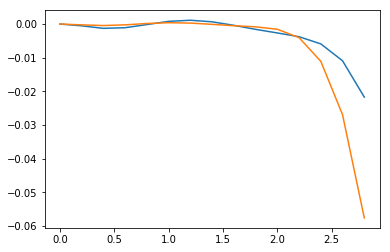

In [9]:
plt.plot(Xs, pred1 - np.sin(Xs), label='diff 1')
plt.plot(Xs, pred2 - (1+Xs**2), label='diff 2')
plt.show()

In [10]:
diff1 = pred1 - np.sin(Xs)
diff2 = pred2 - (1+Xs**2)

In [16]:
print(np.abs(diff1).mean())
print(np.abs(diff2).mean())

0.003503110606772683
0.00695999514601094


In [17]:
print(np.abs(diff1).max())
print(np.abs(diff2).max())

0.0217042698012182
0.05760567744724199
